# Breast Cancer Classification using KNN

In [1]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import train_test_val_split, Preprocessor
from model import KNN

In [2]:
# Read data
df = pd.read_csv('Breast_Cancer.csv')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
# Number of duplicates
df.duplicated().sum()

1

In [4]:
df[df.duplicated()]

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
436,63,White,Married,T1,N1,IIA,Moderately differentiated,2,Regional,17,Positive,Positive,9,1,56,Alive


In [5]:
# Remove duplicates
df = df[~df.duplicated()]
df.duplicated().sum()

0

In [6]:
# Check for null values
df.isnull().any().any()

False

In [7]:
# Schema of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4023 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4023 non-null   int64 
 1   Race                    4023 non-null   object
 2   Marital Status          4023 non-null   object
 3   T Stage                 4023 non-null   object
 4   N Stage                 4023 non-null   object
 5   6th Stage               4023 non-null   object
 6   differentiate           4023 non-null   object
 7   Grade                   4023 non-null   object
 8   A Stage                 4023 non-null   object
 9   Tumor Size              4023 non-null   int64 
 10  Estrogen Status         4023 non-null   object
 11  Progesterone Status     4023 non-null   object
 12  Regional Node Examined  4023 non-null   int64 
 13  Regional Node Positive  4023 non-null   int64 
 14  Survival Months         4023 non-null   int64 
 15  Stat

## Data Exploration

### Univariate Distribution Analysis

From `df.info()`, we can see that there are only 5 numerical value columns and the others are categorical variables, which can also be confirmed from the displayed result of df.head() function above. We can fetch numerical and categorical columns separately based on their datatypes.

In [8]:
# Identification numerical and categorical cols
numerical_cols = []
categorical_cols = []

for col in df.columns:
    if df[col].dtype == int:
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

In [9]:
numerical_cols

['Age',
 'Tumor Size',
 'Regional Node Examined',
 'Regional Node Positive',
 'Survival Months']

In [10]:
categorical_cols

['Race',
 'Marital Status',
 'T Stage ',
 'N Stage',
 '6th Stage',
 'differentiate',
 'Grade',
 'A Stage',
 'Estrogen Status',
 'Progesterone Status',
 'Status']

Now that we have the numerical and categorical columns, we can visualize the values using histograms(numerical) and bar charts(categorical) to find out how they are distributed.

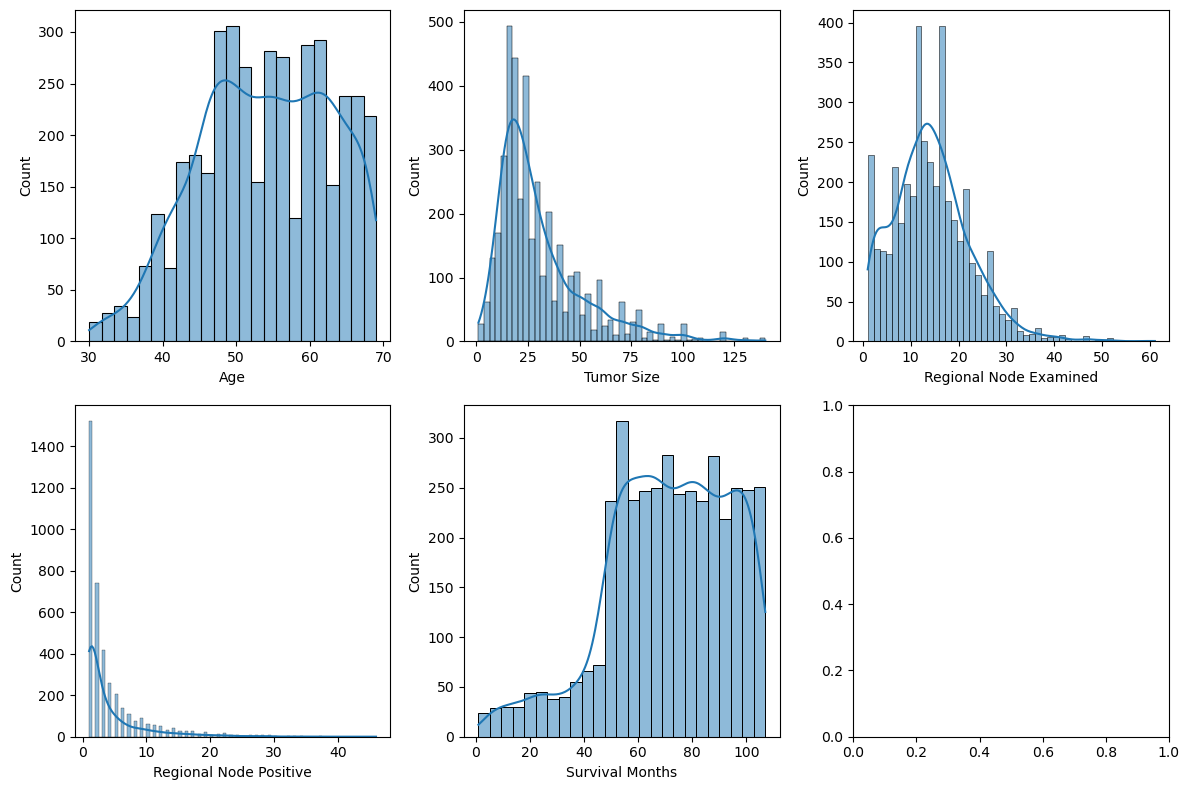

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Create a grid for histograms
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot histograms for each column
for i, column in enumerate(numerical_cols):
    sns.histplot(data=df, x=column, ax=axes[i], kde=True)

plt.tight_layout()
plt.show()

1. **Age**: The distribution of age shows that a lot of patients are those in their mid 40s to 60s. The steep curve before the mid 40s indicate that there are relatively low number of patients who are younger than 40.

2. **Tumor Size**: The distribution of tumor size is unimodal with most patients having tumors of size 0 to 50 millimeters. However, there is also a considerable number of patients who have a tumor size in the range of 75 to 125 millimeters, although their count is low in number. We can compare this tumor size with status of the patient to check if there is a correlation between the tumor size and the patient's status.

3. **Regional Node Examined**: The number of regional nodes that are examied around the tumor node is also unimodally distributed. The mode of this feature lies between 10 and 20, which indicates that most of the times, 10 to 20 regional nodes around the tumor node are examined to assess the spread.

3. **Regional Node Positive**: The distribution of this feature is right skewed and unimodal suggesting that in most of the cases, 0 to 10 regional nodes are found to be positive.

4. **Survival Months**. The histogram of this feature suggests that patients survival range varies from 0 to around 9 years. The most common survival months are 60 to 100. We can differentiate this graph for each stage of cancer to have a better understanding of the distribution.

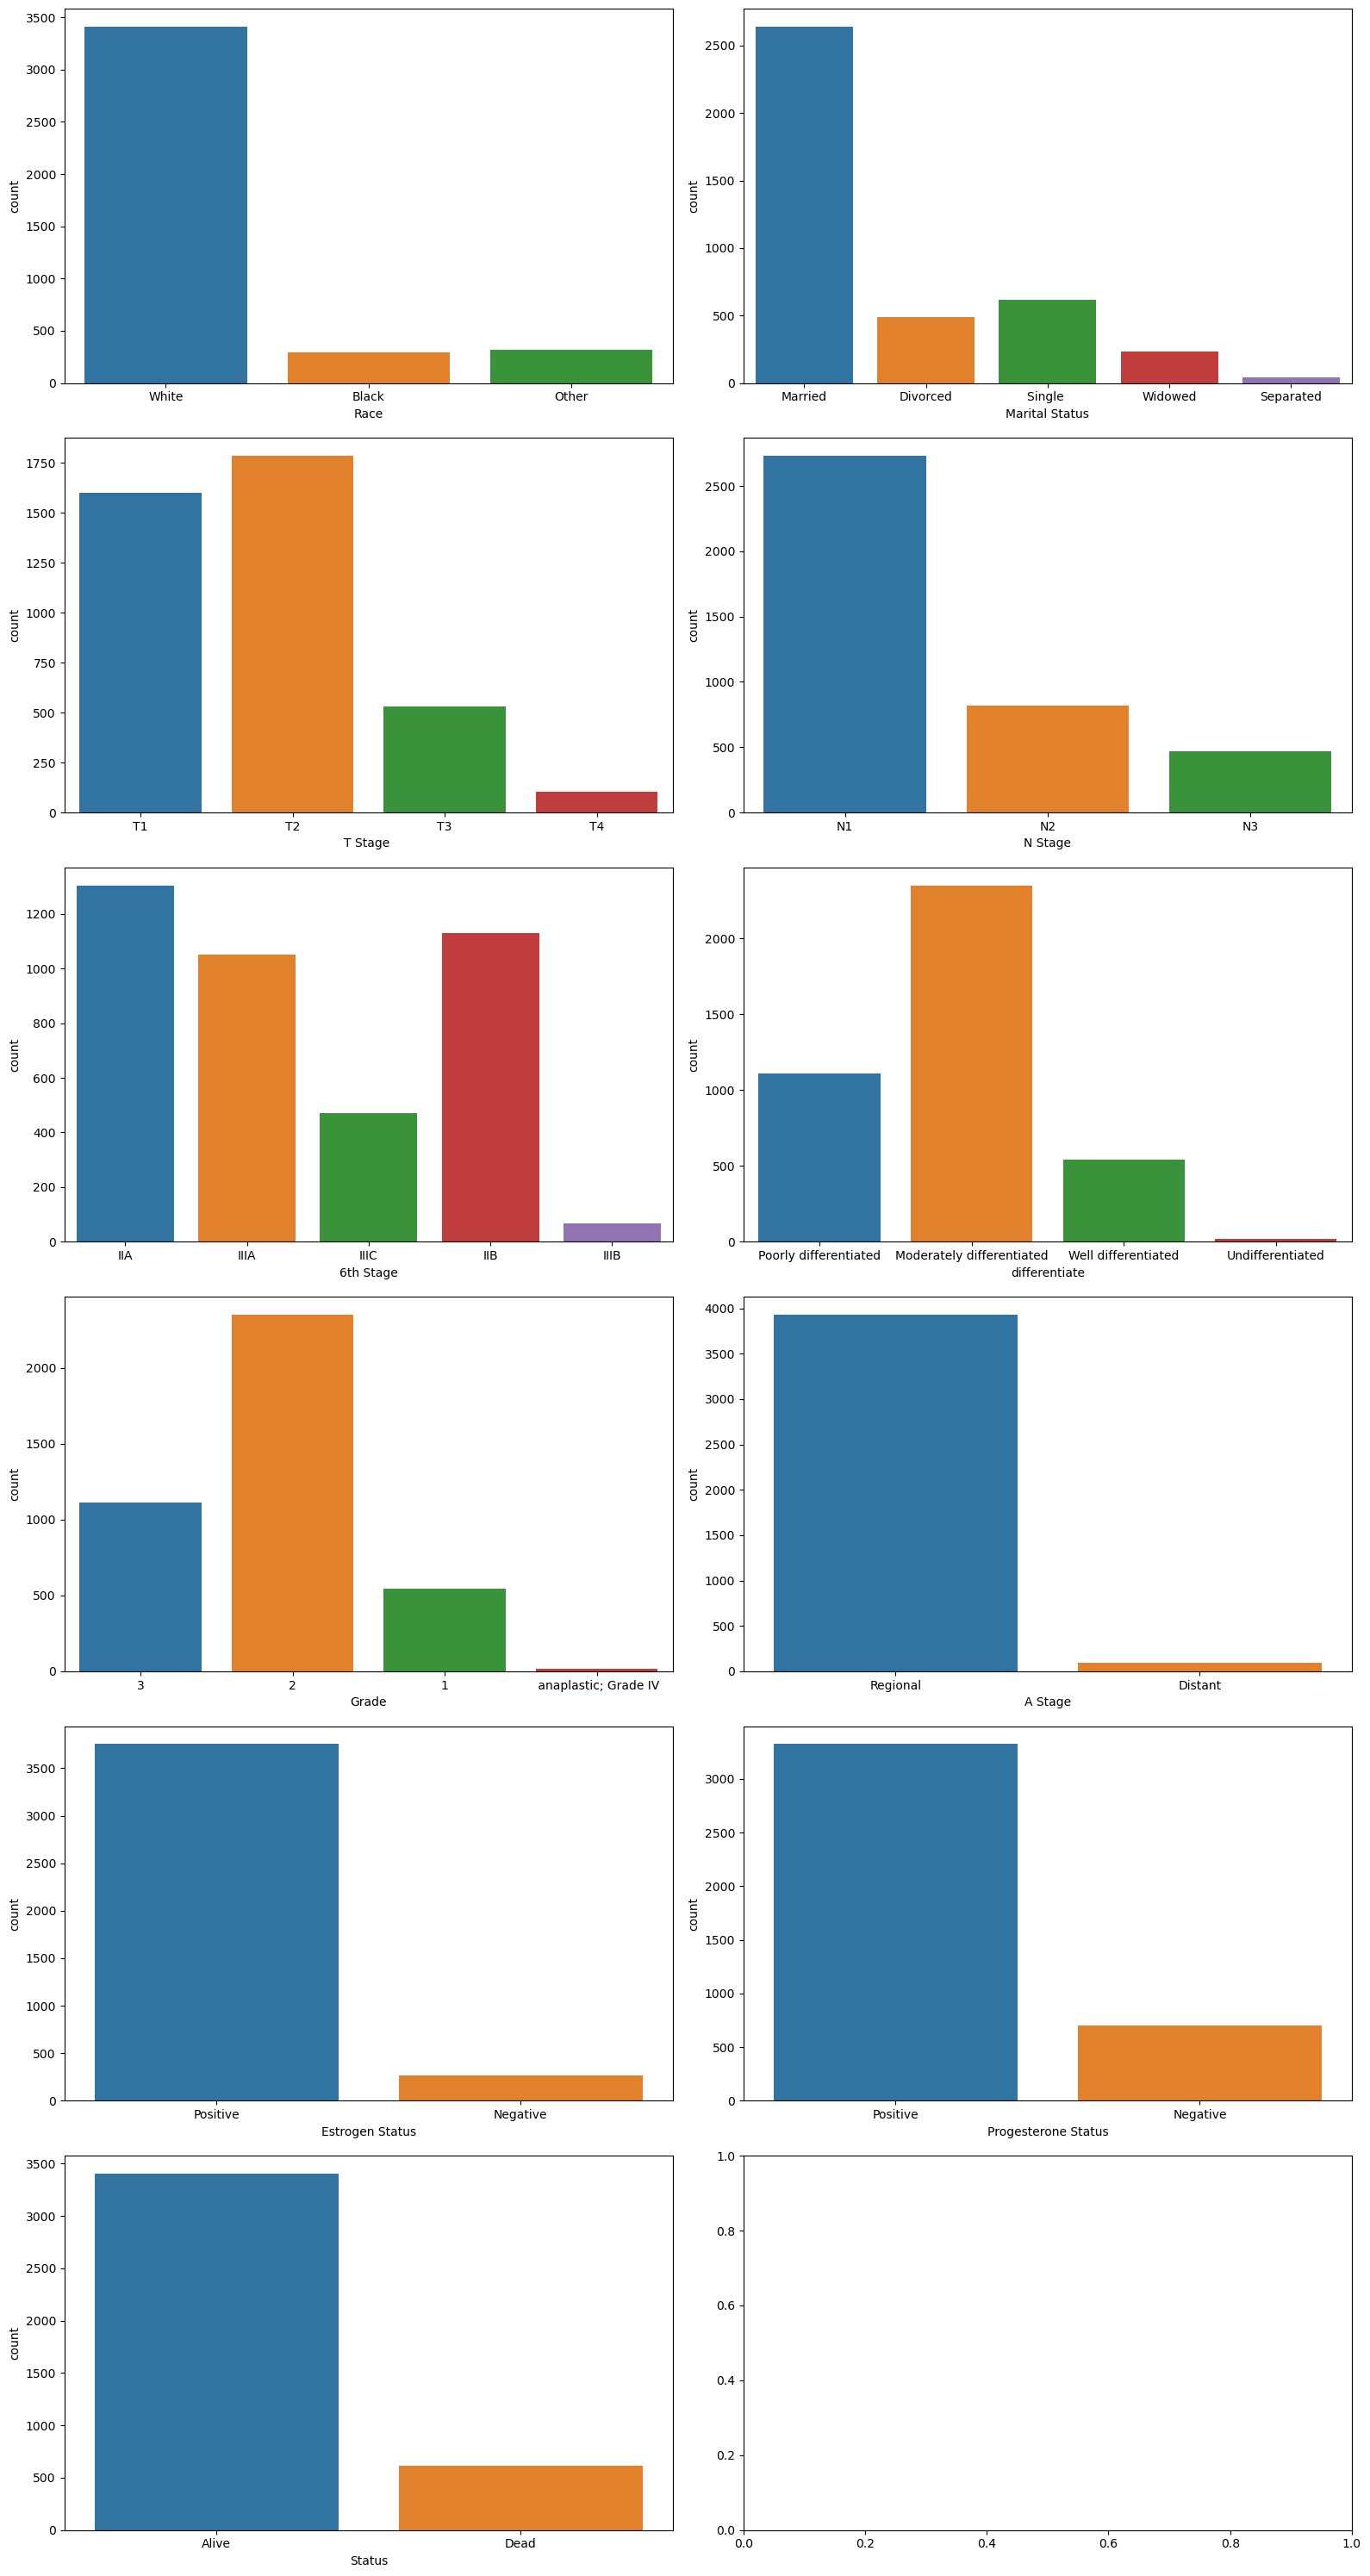

In [12]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 30))  # Create a grid for barplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot countplots/barplots for each column
for i, column in enumerate(categorical_cols):
    sns.countplot(data=df, x=column, ax=axes[i])

plt.tight_layout()
plt.show()

1. **Race**: This dataset contains records of patients who are mostly white. There are 3 times more records for white patients compared the the records of African American people and other races combined. This has the potential to create a bias in the dataset.

2. **Marital Status**: Similar to the `Race` feature, this variable also contains un-ordered categorical features. This column might be one of the columns that might have the least impact on the performance of the model. Most of the patients are married, divorced or widowed which makes sense when the histogram of the `Age` column is taken to consideration. There are a considerable number of patients who are single and very few patients are seperated.

3. **T Stage**: By the time this dataset was collected, most of the patient's tumor stage seems to be on Stage 2 followed by Stage 1. Very few patients have their cancers in Stage 3 and 4. This column can be compared to the `Status` column to find potential correlations between the features. 

4. **N Stage**: The N Stage column indicates the spread of cancer cells to nearby lymph nodes. Most patients have their N Stage in 1st stage, which means very few lymph nodes are affected. There are also a considerable number of patients whose N Stages are in N2/N3 which indicates higher number of lymph nodes affected.

5. **6th Stage**: This column adds a degree of differentiation within each stage. The difference is determined by the size of the tumor and whether the breast cancer has spread to the lymph nodes. However there is a ntable difference when T Stage and 6th Stage. Further domain knowledge might be required to analyze this variable. This distribution of this stage suggests that most patients have their 6th stages in the categories IIA, IIB and IIIA whith a relatively low number of records having their 6th Stages in IIIB and IIIC.

6. **differentiate**: This column has well categorized and ordered values. Most of the patients have their cancer cells moderately differentiable from that of normal cells. Very few number of people have undifferentiable cells which might indicate higher cancer stages.

7. **Grade**: This stage indicates the cancer grade. The plot suggests that there are a lot of 2nd grade cancer patients. There are also a lot of patients whose cancer grades are in grade 1 and 3. But very few number of patients have their cancer in grade 4.

8. **A Stage (Stage)**: This feature represents the stage of the cancer based on the spread of the cancer cells. Most patients have their cancer stages at the Regional level. Very few patients have their cancers in Distant stage.

9. **Estrogen Status**: Almost the entirety of the patients have their Estrogen Receptor cell status Positive. A very low number of patients have negative Estrogen Receptor cells.

10. **Progesterone Status**: Majority of the patients have their progesterone receptor cell status Positive. A very low number of patients have negative progesterone receptor cells. 

11. **Status**: The plot suggests that almost 85 percent of the patients are Alive. This low number of classes might cause class imbalance problem in the model.

There are certain columns that are ordered in nature. For example, columns such as T Stage and N Stage have an inherent order to them. They can be represented as numbers 0, 1, 2, 3 which also has an ordered nature to it. This allows us to convert the ordinal columns to numerical columns.

Similarly, columns such as A Stage, Estrogen Status, Progesterone Status and the dependent column Status have only two categories associated to them. They can also be converted to binary values 0 and 1, which makes it easier for computational purposes.

The other two columns that are Race and Marital Status are purely categorical and have no order in their categories. They can be used as they are, and the distance between them can be computed via Hamming Distance.

```
ordered_cols = T Stage, N stage, 6th Stage, differentiate, Grade
binary_cols = A stage, Estrogen Status, Progesterone Status
un_ordered_cols = Race, Marital Status
numerical_cols = 'Age', 'Tumor Size','Regional Node Examined', 'Regional Node Positive', 'Survival Months'
```

### Data Exploration using Scatter plots

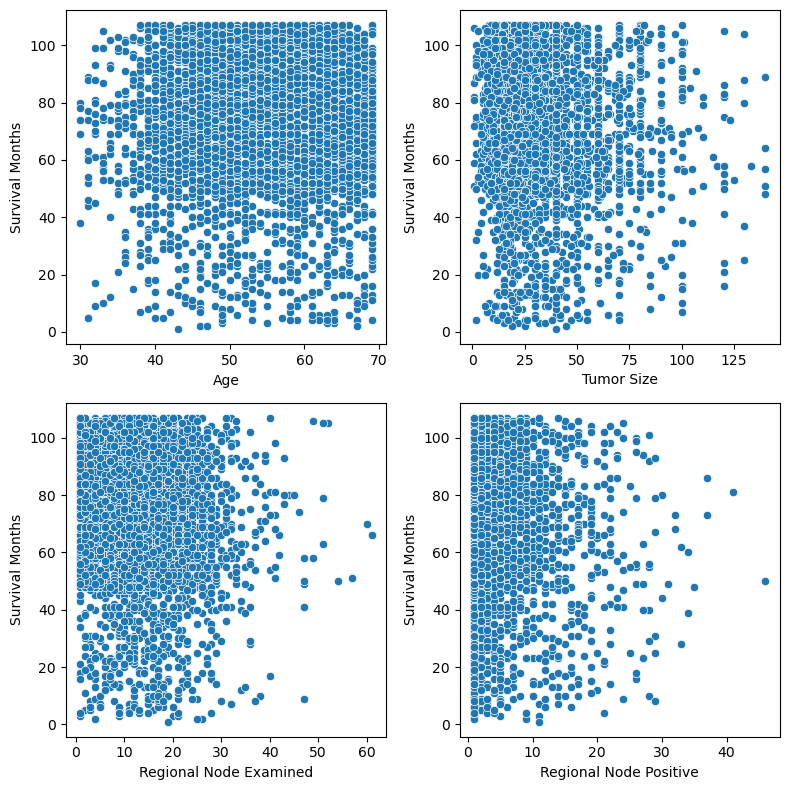

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(8,8)) # Create a grid for scatterplots
axes = axes.flatten() # Flatten the axes array for easy iteration

# Plot scatterplots
for ax_num, col in enumerate(numerical_cols[0:4]):
    sns.scatterplot(data=df, x=col, y='Survival Months', ax=axes[ax_num])
    
plt.tight_layout()
plt.show()

In [14]:
# Pearson Correlation
x_col = 'Survival Months'
y_cols = ['Age', 'Tumor Size','Regional Node Examined', 'Regional Node Positive']

for y_col in y_cols:
    corr_val = np.corrcoef(df[x_col], df[y_col])
    print(f"Pearson Correlation between {y_col} and {x_col} is {corr_val[0][1]}")

Pearson Correlation between Age and Survival Months is -0.009224096738733516
Pearson Correlation between Tumor Size and Survival Months is -0.08701632449144174
Pearson Correlation between Regional Node Examined and Survival Months is -0.022166396984595663
Pearson Correlation between Regional Node Positive and Survival Months is -0.13533033625029547


1. The scatter plot between `Age` and `Survival Months` suggests no particular linear relationships, However, there are a very few data points for patients having age under 40 and patients having survival months less that 40 months. The Pearson Correlation coefficient value of 0.009 suggests that there is almost no relationship between these two features.

2. Similarly, `Tumor Size` and `Survival Months` have a Pearson Correlation coefficient of -0.08 which is close to 0 indicating that there is almost no correlation between these features. This is supported by the scatter plot.

3. The scatter plot between the features, `Regional Node Examined` and `Survival Months` and the Pearson Coefficient between these features suggest no notable relationship. There are a very few patients with more than 30 regional nodes examined,

4. There isn't any correlation between `Survival Months` and `Regional Node Positive`. Most of the patients have around 10 regional nodes positive and a relatively low number of patients have positive regional nodes higher than that.

### Distribution of categorical features based on Status

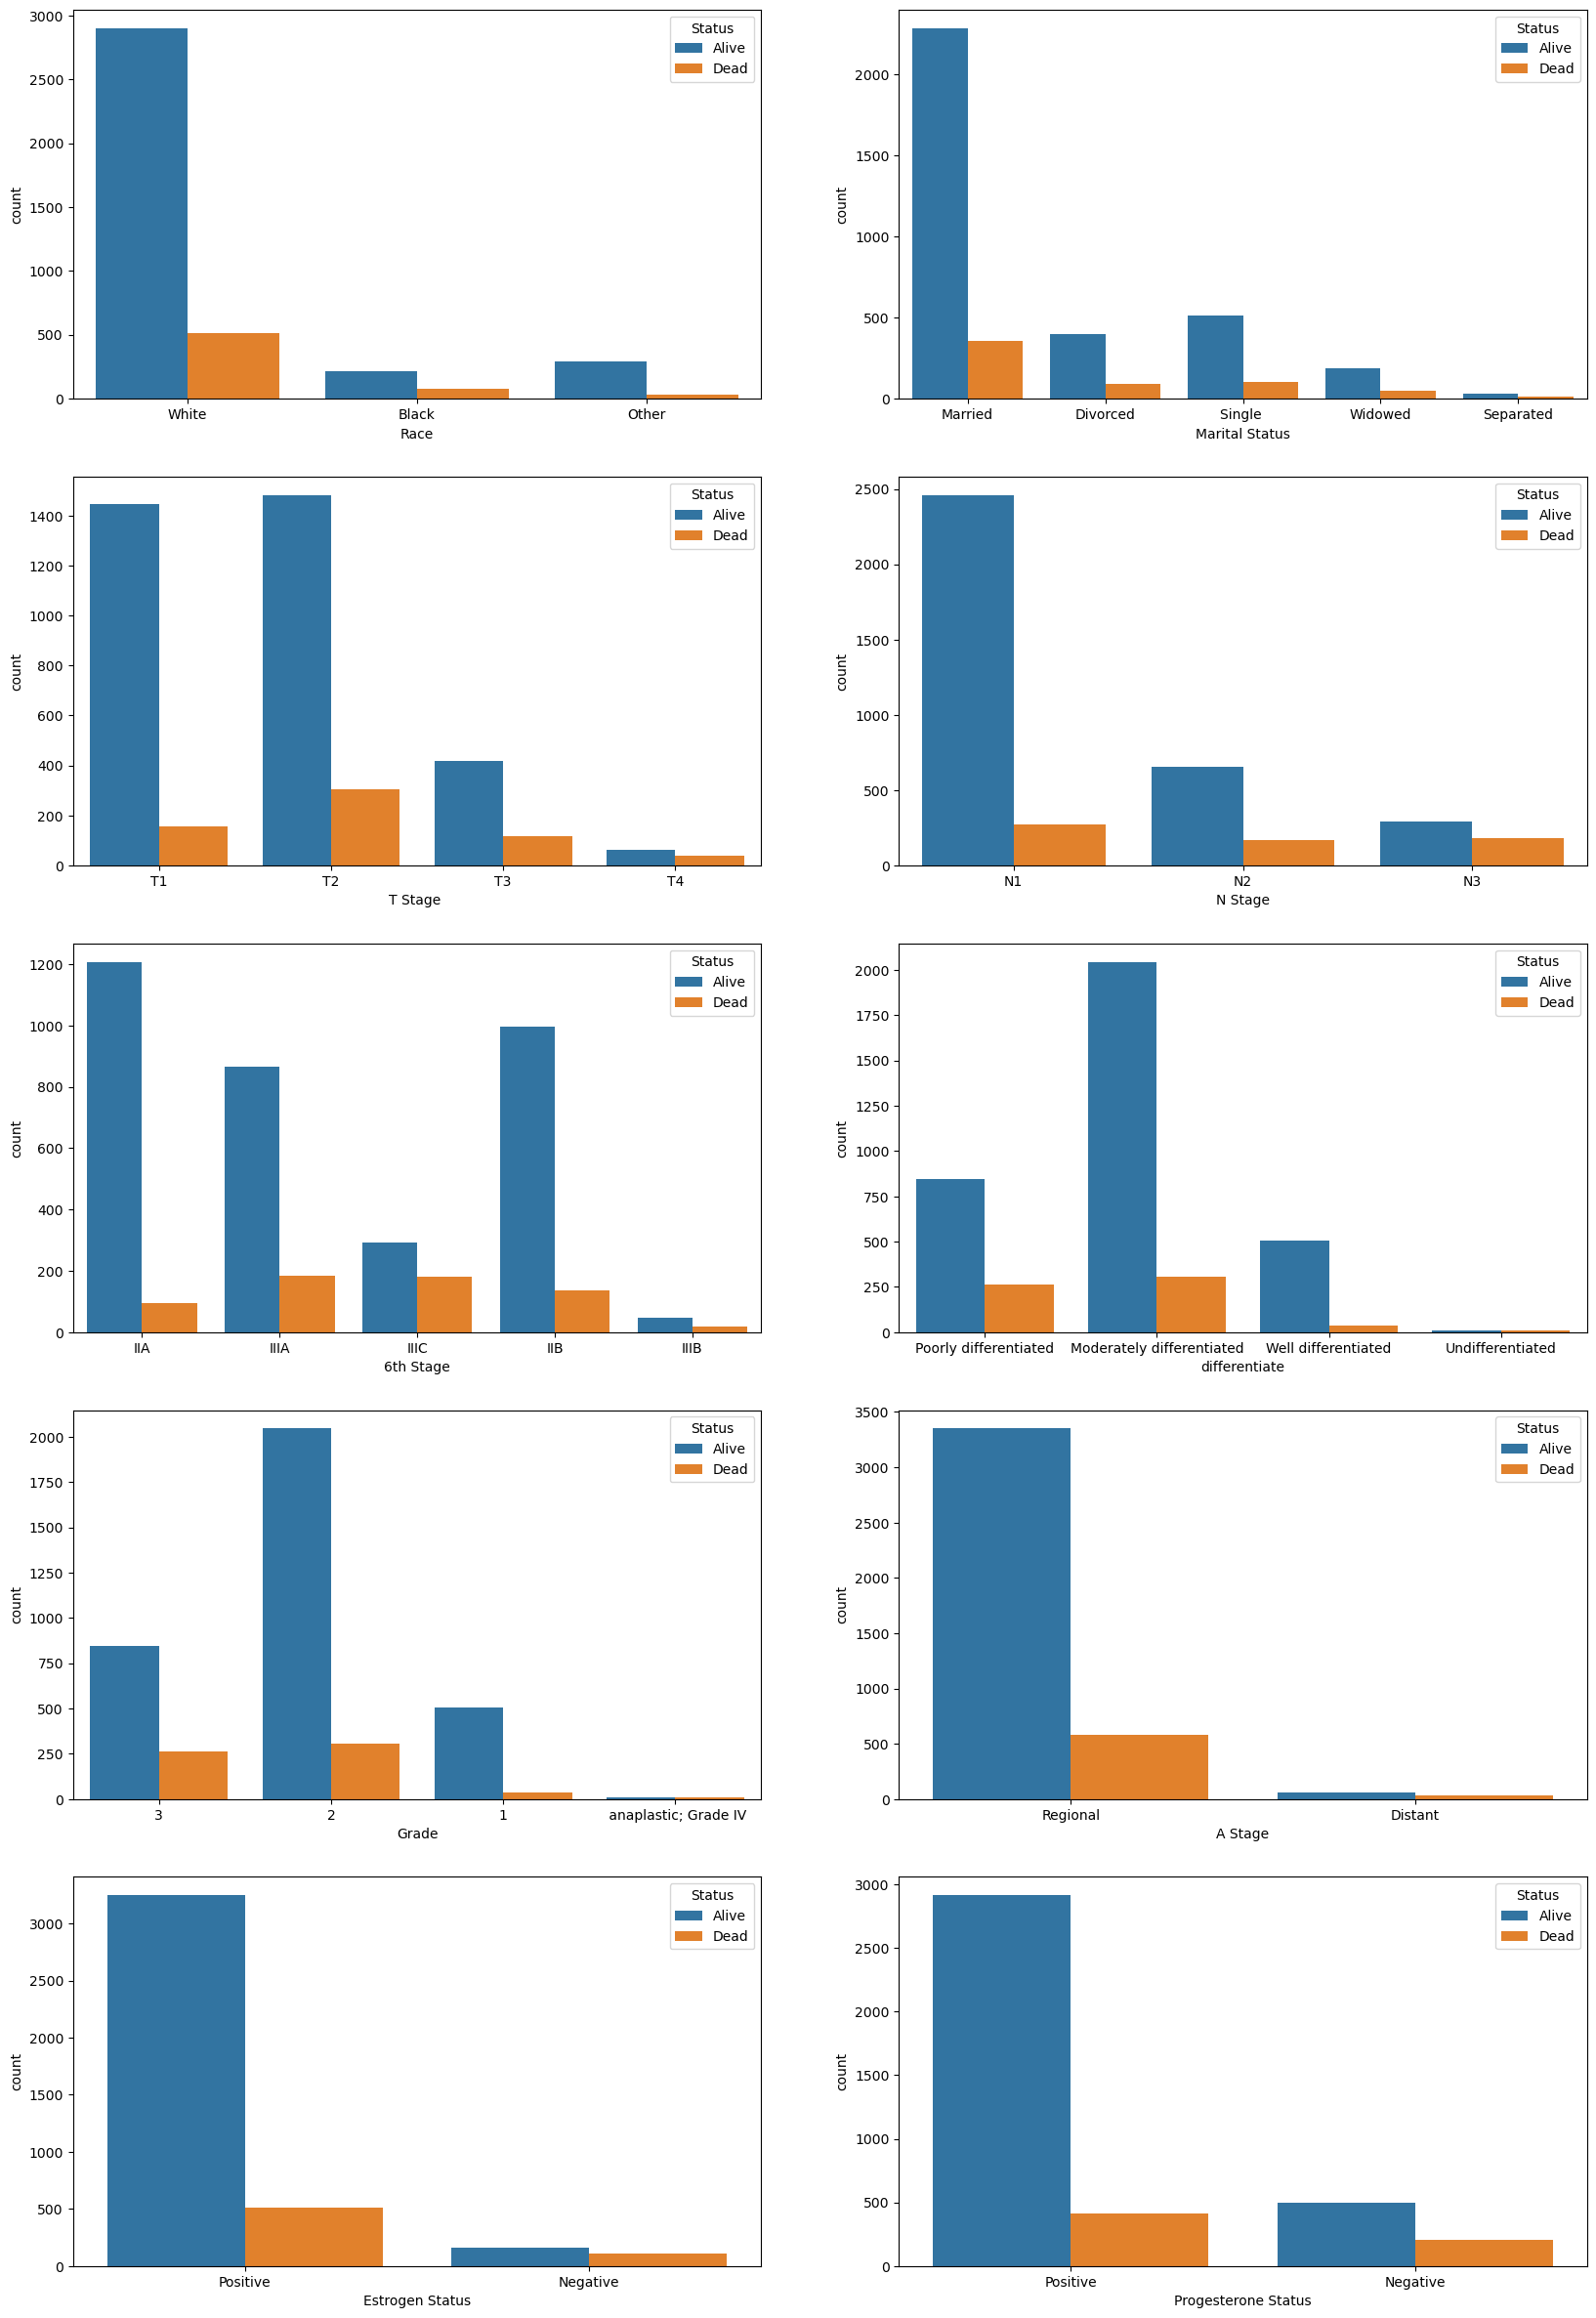

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,30))  # Create grids for barplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot barplots categorized based on Patient status
for ax_num, col in enumerate(categorical_cols[0:len(categorical_cols)-1]):
    sns.countplot(data=df, x=col, hue='Status', ax=axes[ax_num])

The most notable findings from these graphs are:

1. Patients having T Stage T4, N Stage N3, 6th Stage IIC and IIIB, undifferentiable degree of differentiation and cancer stage IV have lower chances of survival compared to the other patients in the respective categories.

2. Similarly patients having Distant spread of cancer cells, Negative ER cells and Negative PR cells have lower chances of survival.

## Data Preprocessing

In [16]:
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


The `train_test_val_split` function can be used to split the dataset into train, validation and test datasets. Since there is a class imbalanced (observed from univariate analysis), data has been splitted in stratified manner. 

The `Preprocessor` class is used to pre-process the train dataset and the categorical codes are retained along with the instance, so that they can produce the same categorical codes when implemented on the val/test datasets.

Note that unordered categorical columns are retained, since hamming distance has been used to calcuate the distance between values in such features.

In [17]:
# Split data to train, validation and test datasets
train, val, test = train_test_val_split(df, train_size=0.7, val_size=0.15)

In [18]:
# Preprocess the train dataset - convert ordinal columns to numerical columns
ordinal_cols = ['T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade',
                'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']
pre_processor = Preprocessor()
pre_proc_train = pre_processor.convert_ordinal_to_numerical_train(train, ordinal_col_lst=ordinal_cols)

In [19]:
# Preprocess the validation dataset
pre_proc_val = pre_processor.convert_ordinal_to_numerical_test(val)

## Model Training and Hyper-parameter Tuning

For the model, the `KNN` class has been used. Euclidean distance has been used for computing the distance between numerical and ordinal variables and hamming distances for categorical non-ordered columns.

The model also has inbuilt methods to compute evaluation metrics such as accuracy, balanced accuracy and F1 score.

Class Structure:

1. Fit stage: Given the list of numerical and categorical columns, the data is split into two numpy arrays which will allow for simpler calculations

2. Predict stage: Calls `_predict_for_each_instance` method for each of the test variable. Returns the array of predicted classes.

3. Predict_for_each_instance: For each given test sample, compute euclidean distance for the numerical columns and the hamming distance for the categorical columns. Finds the sum of these distances, sorts them and picks the shortest `k` distances and returns its mode.

In [20]:
# Apply the KNN model on pre-processed dataset.
target_col = 'Status'
categorical_cols = ['Race', 'Marital Status']
num_cols = [column for column in pre_proc_train.columns if column not in categorical_cols+[target_col]]

# Lists to store metrics
accuracies = []
balanced_accuracies = []
f1_scores = []

# Fit model on training dataset for different k values
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

for k in k_values:
    model = KNN(k=k)
    model.fit(df=pre_proc_train, target_col=target_col, numerical_cols=num_cols, categorical_cols=categorical_cols)

    # Predict for val dataset
    result = model.predict(pre_proc_val)

    # Print Accuracy
    accuracies.append(model.get_accuracy())
    balanced_accuracies.append(model.get_balanced_accuracy())
    f1_scores.append(model.get_f1_score())
    
    print("Model completed for k value ", k)

Model completed for k value  1
Model completed for k value  3
Model completed for k value  5
Model completed for k value  7
Model completed for k value  9
Model completed for k value  11
Model completed for k value  13
Model completed for k value  15


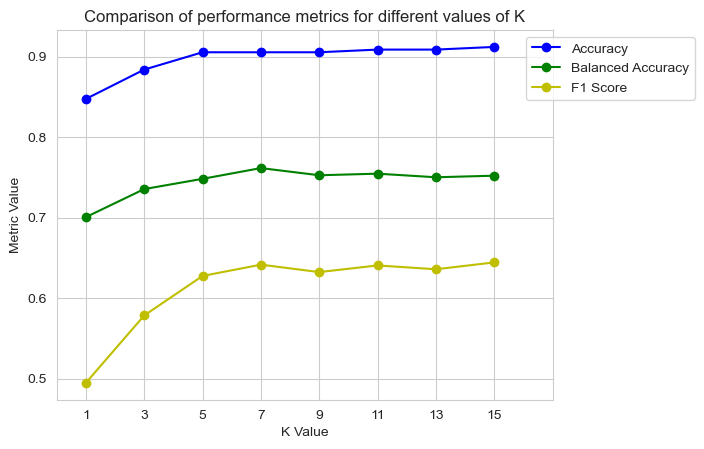

In [21]:
plt.figure()
sns.set_style('whitegrid')
plt.plot(k_values, accuracies, '-ob', label='Accuracy')
plt.plot(k_values, balanced_accuracies, '-og', label='Balanced Accuracy')
plt.plot(k_values, f1_scores, '-oy', label='F1 Score')
plt.xlim(0, 17)
plt.xticks(list(range(1,17, 2)))
plt.xlabel("K Value")
plt.ylabel("Metric Value")
plt.title("Comparison of performance metrics for different values of K")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [22]:
print(f"The K value {k_values[np.argmax(accuracies)]} provides the best accuracy")
print(f"The K value {k_values[np.argmax(balanced_accuracies)]} provides the best balanced accuracy")
print(f"The K value {k_values[np.argmax(f1_scores)]} provides the best F1 Score")

The K value 15 provides the best accuracy
The K value 7 provides the best balanced accuracy
The K value 15 provides the best F1 Score


## Testing

In [23]:
# Split dataset into train and test values
train, test = train_test_val_split(df, concat_train_val=True)

# Preprocess the train dataset - convert ordinal columns to numerical columns
ordinal_cols = ['T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade',
                'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']
pre_processor = Preprocessor()
pre_proc_train = pre_processor.convert_ordinal_to_numerical_train(train, ordinal_col_lst=ordinal_cols)

# Preprocess the test dataset
pre_proc_test = pre_processor.convert_ordinal_to_numerical_test(test)

# Model parameters
target_col = 'Status'
categorical_cols = ['Race', 'Marital Status']
num_cols = [column for column in pre_proc_train.columns if column not in categorical_cols+[target_col]]

for k in [7, 15]:
    model = KNN(k=k)
    model.fit(df=pre_proc_train, target_col=target_col, numerical_cols=num_cols, categorical_cols=categorical_cols)

    # Predict for test dataset
    result = model.predict(pre_proc_test)

    # Print Accuracy
    print(f"Accuracy for k value {k}: {model.get_accuracy()}")
    print(f"Balanced Accuracy for k value {k}: {model.get_balanced_accuracy()}")
    print(f"F1 score for k value {k}: {model.get_f1_score()}")
    print("-----------------------------------------------------")

Accuracy for k value 7: 0.8859504132231405
Balanced Accuracy for k value 7: 0.6818296370967742
F1 score for k value 7: 0.5106382978723403
-----------------------------------------------------
Accuracy for k value 15: 0.8892561983471075
Balanced Accuracy for k value 15: 0.6793829805107527
F1 score for k value 15: 0.510948905109489
-----------------------------------------------------


## Final thoughts

This model is desgined specifically for binary classification task. If a person is planning to deploy this system, some of the thoughts/questions/concerns that arise are:

1. Are the characteristics of the population of patients whose data is to be fed into the model similar to that of the patient samples the model has been trained on? If yes, then the model might perform good. Else, there might be a need to retrain the model on a new dataset that closely resembles the population of the hospital's patients.

2. The model has a balanced accuracy of 75% on the test dataset. The performance of this model on a generalized data is uncertain. Hence this model must always be used for supporting opinions rather than a sole decision making model.